*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

In [1]:
from pylab import rcParams
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 10, 5

In [2]:
import numpy as np
import sde_solvers as sde
from scipy import stats
import matplotlib.pyplot as plt
import stochastic_plots as stoch
import arrival_process_simulation as arrival

np.random.seed(42)

# Continuous-time stochastic processes - HW 2

*The code developed below for Python 3.x is PEP8 compliant as verified by [autopep8](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/code_prettify/README_autopep8.html).*

## Euler integration scheme for ODE's

In [3]:
# Define ODE
mu = 1.3
def a(t, x): return mu*x


# Define initial conditions
t0, x0 = 0.0, 100.0

# Define the simulation parameters
T = 2.0   # Length of simulation interval
N = 1000  # Number of steps in simulation

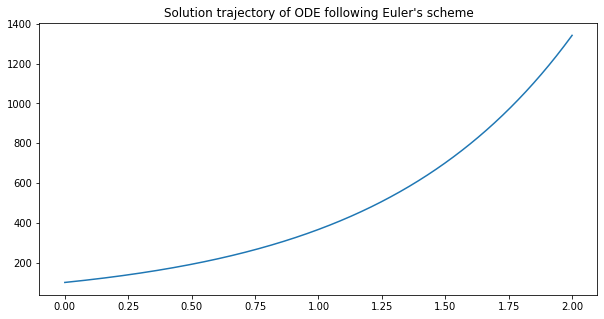

In [4]:
t, X_ode = sde.ode_euler(t0, x0, T, a, N)
plt.title("Solution trajectory of ODE following Euler's scheme")
_ = plt.plot(t, X_ode)

## Integration schemes for SDE's

In [5]:
# Define SDE
mu = 1.3
sigma = 0.4
def a(t, x): return mu*x
def b(t, x): return sigma*x
def db_dx(t, x): return sigma


# Define initial conditions
t0, x0 = 0.0, 100.0

# Define the simulation parameters
M = 10000  # Number of trajectories for simulation
T = 2.0   # Length of simulation interval
N = 1000  # Number of steps in simulation

### Stochastic Euler integration (Euler- Maruyana) scheme

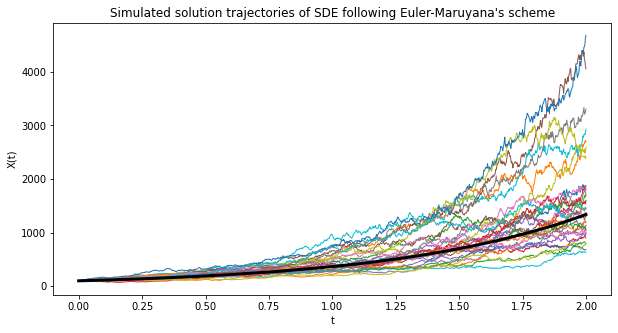

In [6]:
# Carry out simulation
t, X_euler = sde.euler_maruyana(t0, x0, T, a, b, M, N)

# Plot trajectories
stoch.plot_trajectories(t, X_euler, fig_num=1, max_trajectories=30)
_ = plt.title(
    "Simulated solution trajectories of SDE following Euler-Maruyana's scheme")

### Milstein integration sheme

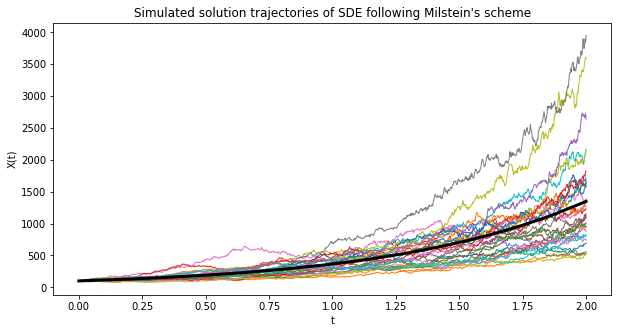

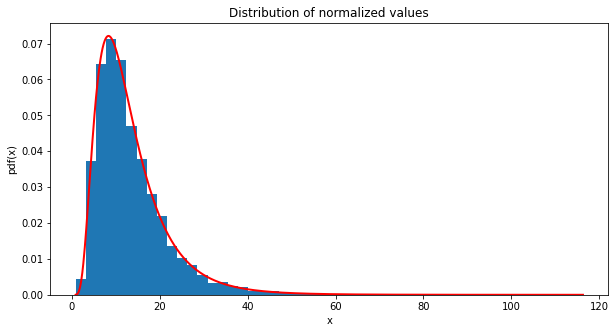

In [7]:
t, X_milstein = sde.milstein(t0, x0, T, a, b, db_dx, M, N)

# Plot trajectories
stoch.plot_trajectories(t, X_milstein, fig_num=1, max_trajectories=30)
plt.title(
    "Simulated solution trajectories of SDE following Milstein's scheme")

# Plot histogram
def pdf(x):
    return stats.lognorm.pdf(x, sigma*np.sqrt(T),
                             0.0, np.exp((mu - 0.5*sigma**2)*T))


xT = X_milstein[:, -1]
stoch.plot_pdf(xT/x0, pdf, fig_num=2)
_ = plt.title("Distribution of normalized values")

### Jump simulator

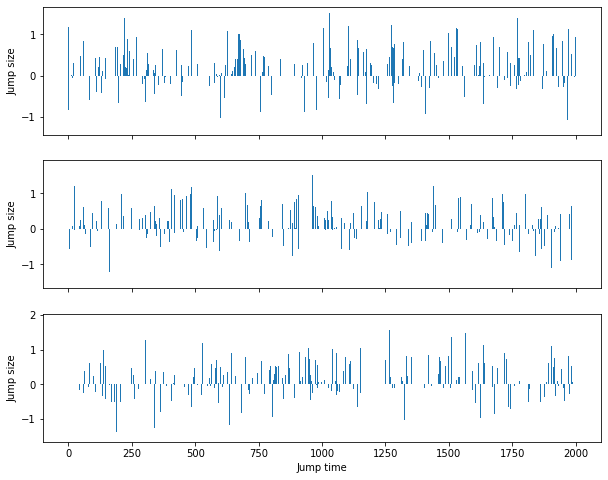

In [8]:
# Define jump process
lambda_rate = 0.5
def simulator_arrival_times(t0, T):
    return arrival.simulate_poisson(t0, t0 + T, lambda_rate, M=1)[0]
def simulator_jump_sizes(N): return 0.2 + 0.5*np.random.randn(N)
def simulator_jump_process(t0, T, M):
    return sde.simulate_jump_process(t0, T,
                                     simulator_arrival_times,
                                     simulator_jump_sizes,
                                     M)


# Simulation parameters
t0 = 0.0
T = 2000.0
M = 3

# Simulate jump processes
times_of_jumps, sizes_of_jumps = simulator_jump_process(t0, T, M)

# Plot simulation
fig, axs = plt.subplots(M, sharex=True, num=1, figsize=(10, 8))
axs[M-1].set_xlabel("Jump time")
for m in range(M):
    axs[m].set_ylabel("Jump size")
    axs[m].bar(times_of_jumps[m], sizes_of_jumps[m])

### Jump-diffusion SDE

We wish to simulate the following SDE with jumps:

$$
X(t_0)=x_0, \
dX(t)=a(t,X(t))\,dt + b(t, X(t))\,dW(t)+c(t, X(t^-))\, dJ(t).
$$

Let $\{t^*_1 < t_2^* < \dots < t^*_{N_1}=T\}$ be a regular grid of $N_1$ points, and let $\{\tau_1 < \tau_2 < \dots < \tau_{N_2}\}$ be the set of jump times simulated in $[t_0,t_0+T]$, each with intensity $Y_j \sim f_{Y}(y)$. We consider the following jump-adapted (non-regular) grid,

$$
\{t_1,\dots, t_{N}\}= \{t^*_1,\dots t^*_{N_1}\} \cup \{\tau_1,\dots,\tau_{N_2}\},
$$

and we define $\Delta T_n = t_{n+1}-t_{n}$ for all $n$. For convenience, let $\xi_n$ denote the approximation of $X(t)$ at time $t_n$. For a single simulation, we proceed as follows:

1. Set $\xi_0=x_0$.
  
2. For a generic approximation $\xi_{n+1}$, we perform the following calculations:
  
    - Set $\xi_{n+1}^-=\xi_n + a(t_n, \xi_n)\Delta T_n+b(t_n, \xi_n)\sqrt{\Delta T_n}Z_n$, where $Z_n \sim \mathcal N(0,1)$ iid.
   
    - Take the possible jump into account by setting the definitive approximation as  
$$
    \xi_{n+1}=\xi_{n+1}^- + c(t_{n+1}, \xi_{n+1}^-)\Delta J_n,
$$
where $\Delta J_n$ is defined as:
    
$$
    \Delta J_n =\begin{cases}
      Y_j& \text{if } \exists j: t_{n+1}=\tau_j,\\
      0& \text{otherwise}.
    \end{cases}
$$

Note that in each step there can be at most one jump (since the jump times are included in the grid). Finally, we return the values of the approximations only at the original regular grid, and we also return the matrices of jump times and sizes (for all simulations).

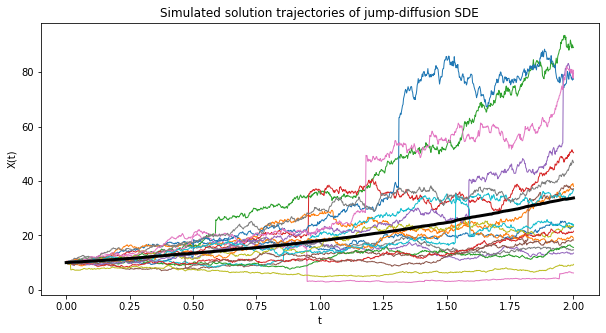

In [9]:
# Define the conditions for the simulation
t0 = 0
x0 = 10.0
T = 2.0
N = 1000
M = 1000

# Define jump-diffusion SDE
def a(t, x): return 5.0*x/x0
def b(t, x): return 3.0*x/x0
def c(t, x): return 10.0*x/x0


# Simulate trajectories
t, X_jump, _, _ = sde.euler_jump_diffusion(t0, x0, T, a, b, c,
                                           simulator_jump_process,
                                           M, N)

# Plot trajectories
stoch.plot_trajectories(t, X_jump, fig_num=10, max_trajectories=20)
_ = plt.title(
    "Simulated solution trajectories of jump-diffusion SDE")